In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightkurve import search_targetpixelfile

%matplotlib inline

/Users/sophia268238/GitHub/astronomy_ml/.venv/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sophia268238/.lightkurve/cache. Please move all the files in the legacy directory /Users/sophia268238/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


# Data
- TOIs are selected randomly based on having data in sector 59 and 73 from [ExoFop](https://exofop.ipac.caltech.edu/tess/view_toi.php).
- The period and epoch_time were obtained from the corresponding ExoMast full vetting report. For instance [TOI-3725](https://exo.mast.stsci.edu/exomast_planet.html?planet=TOI3725.01)

In [2]:
TARGET="TOI-3726"
"""
toi,tic,period,epoch_time
TOI-3703,TIC 260962960,3.8901335,3286.8176
TOI-3705,TIC 259506033,1.9023129,3286.1709
TOI-3706,TIC 252430813,4.3701795,3286.77
TOI-3709,TIC 356322454,3.2509846,3288.7293
TOI-3721,TIC 143687316,3.5411235,3287.5229
TOI-3725,TIC 339250695,4.7262208,3287.8584
TOI-3726,TIC 122695048,4.8404430882223,3290.4324
TOI-3733,TIC 321436679,2.1263167,3286.362
"""

candidates = [
    {
        "toi": "TOI-3703",
        "tic": "TIC 260962960",
        "period": 3.8901335,
        "epoch_time": 3286.8176,
    },
    {
        "toi": "TOI-3705",
        "tic": "TIC 259506033",
        "period": 1.9023129,
        "epoch_time": 3286.1709,
    },
    { 
        "toi": "TOI-3706",
        "tic": "TIC 252430813",
        "period": 4.3701795,
        "epoch_time": 3286.770,
    },
    {
        "toi": "TOI-3709",
        "tic": "TIC 356322454",
        "period": 3.2509846,
        "epoch_time": 3288.7293,
    },
    {
        "toi": "TOI-3721",
        "tic": "TIC 143687316",
        "period": 3.5411235,
        "epoch_time": 3287.5229,
    },
    {
        "toi": "TOI-3725",
        "tic": "TIC 339250695",
        "period": 4.7262208,
        "epoch_time": 3287.8584,
    },
    {
        "toi": "TOI-3726",
        "tic": "TIC 122695048",
        "period": 4.8404430882223,
        "epoch_time": 3290.4324,
    },
    {
        "toi": "TOI-3733",
        "tic": "TIC 321436679",
        "period": 2.1263167,
        "epoch_time": 3286.3620,
    },
]

In [3]:
tpfs_list = []
for candidate in candidates:
    print(f"Downloading {candidate['toi']}")
    tpfs_list.append(search_targetpixelfile(candidate["tic"]).download_all())

In [15]:
lc_of_sectors_list = []
for i, tpfs in enumerate(tpfs_list):
    lc_curves = []

    print(f"Extracting lc for {candidates[i]['toi']}:",
          [t.meta["SECTOR"] for t in tpfs if t.meta["SECTOR"] != 86], f'RA={[t.meta["RA_OBJ"] for t in tpfs][0]}',
          f'DEC={[t.meta["DEC_OBJ"] for t in tpfs][0]}')

    for j, t in enumerate(tpfs):
        if t.meta["SECTOR"] == 86:
            continue
        lc_curves.append(t.to_lightcurve())
    lc_of_sectors_list.append(lc_curves)

Extracting lc for TOI-3703: [59, 73, 59, 73] RA=76.09238489229 DEC=44.334131581615
Extracting lc for TOI-3705: [59, 73, 59, 73] RA=75.4802405329849 DEC=50.1312707327049
Extracting lc for TOI-3706: [59, 73, 59, 73] RA=76.8252404347098 DEC=59.7295781497714
Extracting lc for TOI-3709: [59, 73, 59, 73] RA=67.7953104597323 DEC=59.1595873274223
Extracting lc for TOI-3721: [59, 73, 59, 73] RA=80.6115765501831 DEC=40.4260610258505
Extracting lc for TOI-3725: [59, 73, 59, 73] RA=84.7898888833559 DEC=60.424417916589
Extracting lc for TOI-3726: [59, 73, 59, 73] RA=77.298354308809 DEC=38.2285939240944
Extracting lc for TOI-3733: [59, 73, 59, 73] RA=83.1406479012501 DEC=57.6231076438858


# Data Normalization
- Masks are applied to the raw light curves to remove large noises.
- Then the light curves go thorugh outlier removal, flattening and normalization.

In [16]:
cleaned_lc_of_sectors_list=[]
for i, lc_of_sectors in enumerate(lc_of_sectors_list):

    lc_59_0, lc_73_0, lc_59_1, lc_73_1 = lc_of_sectors
    
    mask0 = ((lc_59_0.time.value > 2911) & (lc_59_0.time.value < 2923)) | (lc_59_0.time.value >= 2925)
    lc_59_0_clean = lc_59_0[mask0]
    lc_59_0_clean = lc_59_0_clean.remove_outliers(sigma=5)
    lc_59_0_clean = lc_59_0_clean.flatten(polyorder=1)
    lc_59_0_clean = lc_59_0_clean.normalize()
    
    mask1 = ((lc_73_0.time.value >= 3289) & (lc_73_0.time.value <= 3299)) | (lc_73_0.time.value >=3304)
    lc_73_0_clean = lc_73_0[mask1]
    lc_73_0_clean = lc_73_0_clean.remove_outliers(sigma=5)
    lc_73_0_clean = lc_73_0_clean.flatten(polyorder=1)
    lc_73_0_clean = lc_73_0_clean.normalize()

    mask2 = ((lc_59_1.time.value > 2912) & (lc_59_1.time.value < 2923)) | (lc_59_1.time.value >= 2926)
    lc_59_1_clean = lc_59_1[mask2]
    lc_59_1_clean = lc_59_1_clean.remove_outliers(sigma=5)
    lc_59_1_clean = lc_59_1_clean.flatten(polyorder=1)
    lc_59_1_clean = lc_59_1_clean.normalize()

    cleaned_lc_of_sectors_list.append([lc_59_0_clean, lc_73_0_clean, lc_59_1_clean])


# Visualization

## Normalized Light Curves

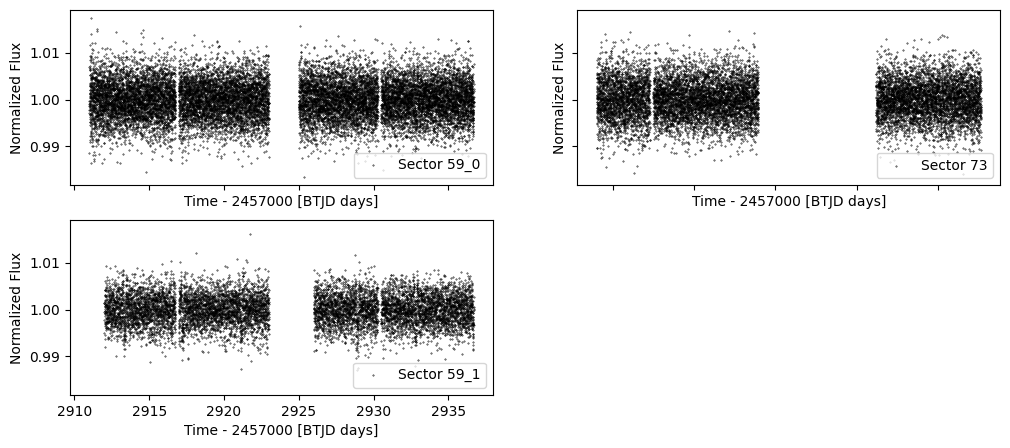

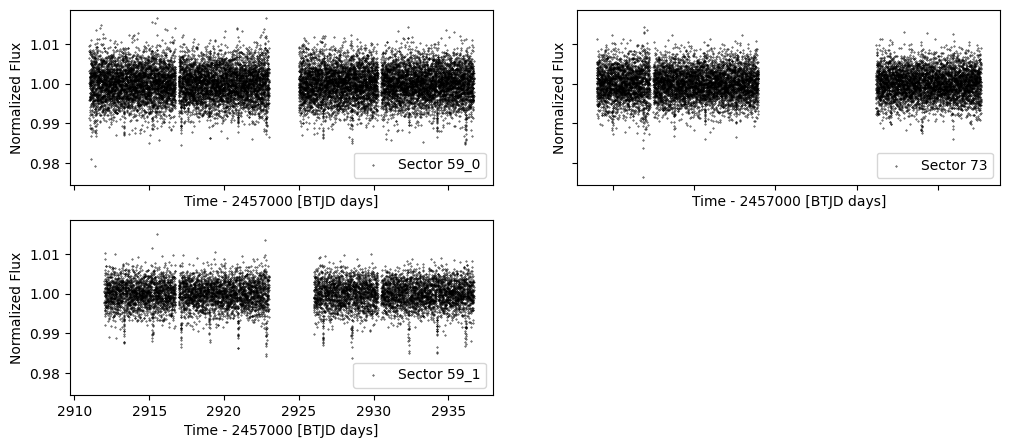

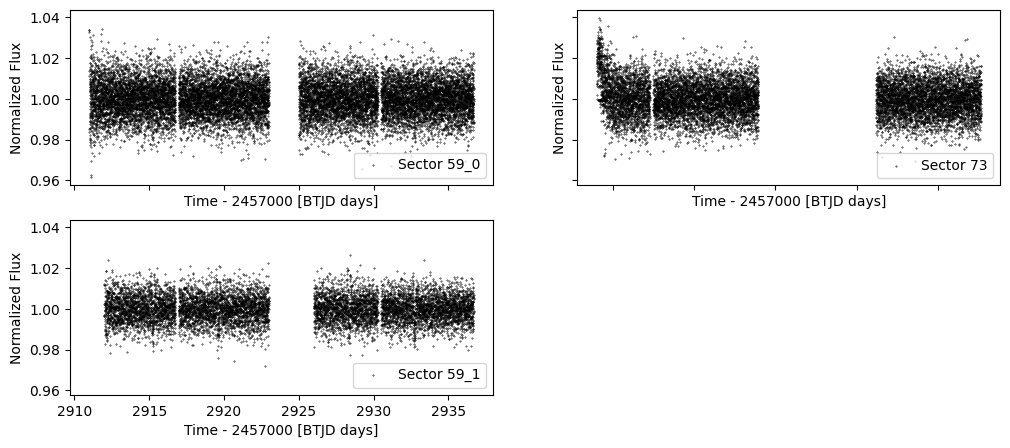

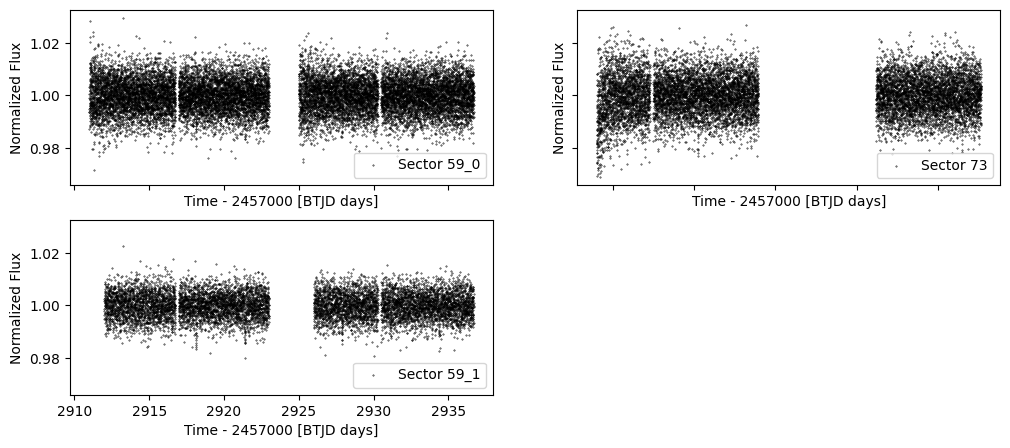

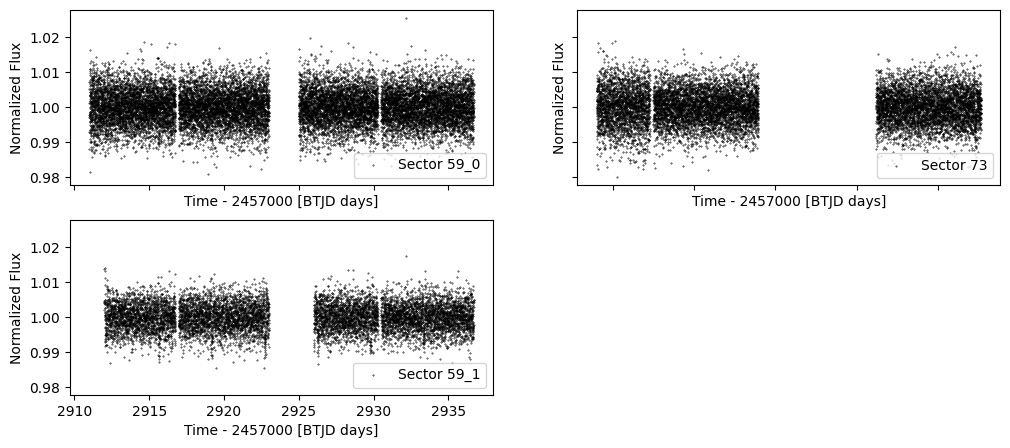

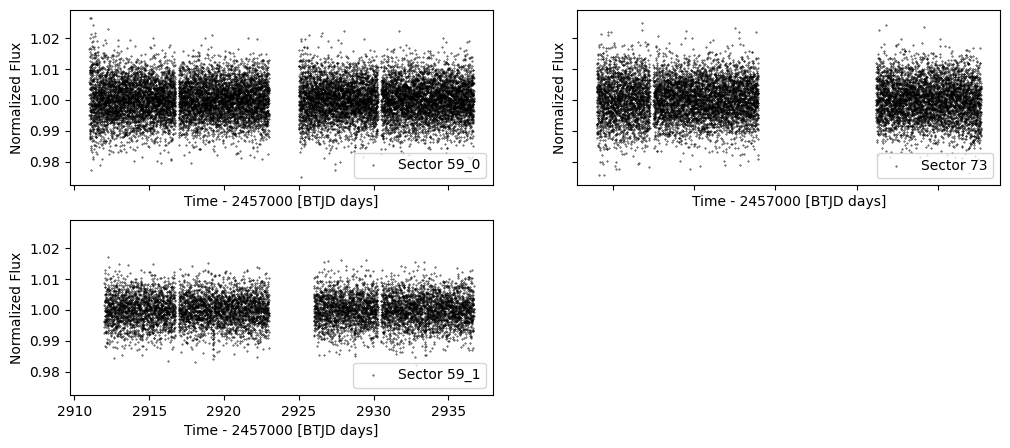

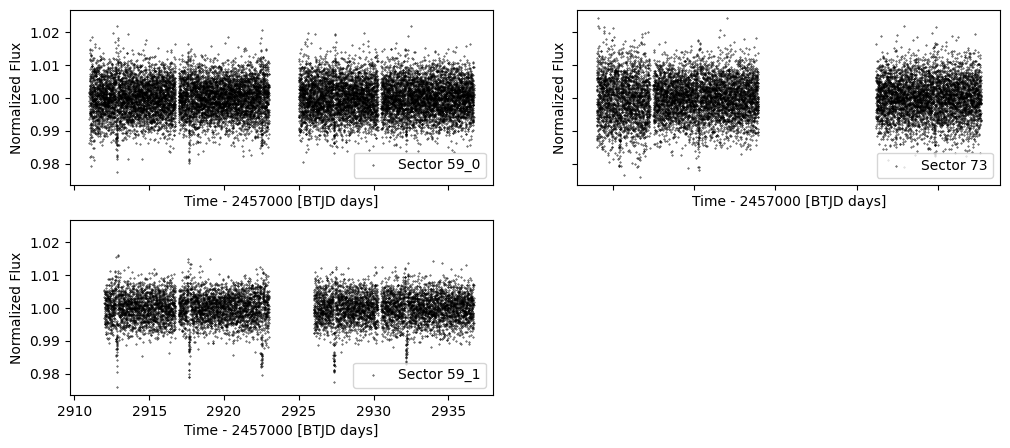

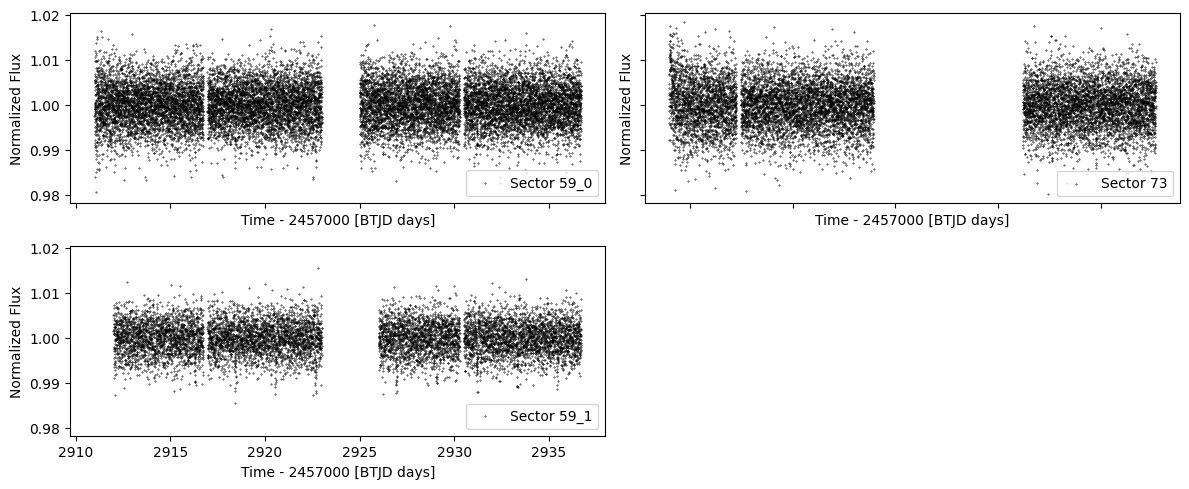

In [17]:
for i, clean_lc_of_sectors in enumerate(cleaned_lc_of_sectors_list):
    toi, period, epoch_time = candidates[i]["toi"], candidates[i]["period"], candidates[i]["epoch_time"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 5), sharey=True, sharex="col")
    axes[1, 1].axis('off')

    lc_59_0_clean, lc_73_0_clean, lc_59_1_clean = clean_lc_of_sectors
    
    lc_59_0_clean.scatter(ax=axes[0, 0], s=0.5, c="black")
    lc_73_0_clean.scatter(ax=axes[0, 1], s=0.5, c="black")
    lc_59_1_clean.scatter(ax=axes[1, 0], s=0.5, c="black")
    axes[0, 0].legend(["Sector 59_0"], loc='lower right')
    axes[0, 1].legend(["Sector 73"], loc='lower right')
    axes[1, 0].legend(["Sector 59_1"], loc='lower right')

plt.tight_layout()

## Folded and Binned Light Curves

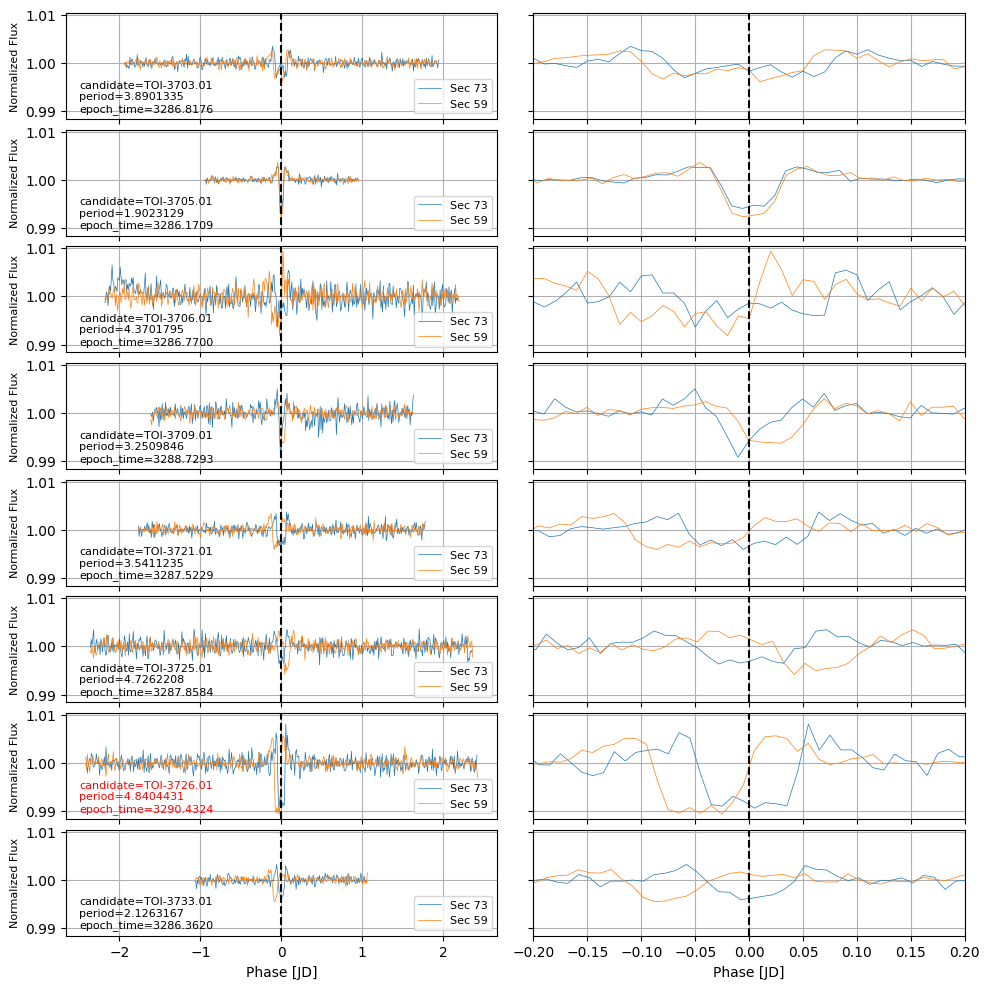

In [70]:
TIME_BIN_SIZE = 0.01
fig, axes = plt.subplots(len(candidates), 2, figsize=(10, 10), sharey=True, sharex="col")
for i, clean_lc_of_sectors in enumerate(cleaned_lc_of_sectors_list):
    toi, period, epoch_time = candidates[i]["toi"], candidates[i]["period"], candidates[i]["epoch_time"]
    title_color = "red" if toi == TARGET else "black"

    ax_0 = axes[i, 0]
    # ax_0.set_title(f"{toi}: Folded LC (Full) of Sector 59 and 73", color=title_color, fontsize=9)
    ax_0.text(-2.5, 0.99, f"candidate={toi}.01\nperiod={period:.7f}\nepoch_time={epoch_time:.4f}", fontsize=8, color=title_color)
    ax_0.set_ylabel(ax_0.get_ylabel(), fontsize=8)


    ax_1 = axes[i, 1]
    # ax_1.set_title(f"{toi}: Folded LC (Zoomed-in) of Sector 59 and 73", color=title_color, fontsize=9)
    ax_1.set_xlim(-0.2, 0.2)
    ax_1.set_ylabel(None, fontsize=8)

    
    lc_59_0_clean, lc_73_0_clean, lc_59_1_clean = clean_lc_of_sectors

    binned_lc = lc_73_0_clean.fold(period=period, epoch_time=epoch_time).bin(time_bin_size=TIME_BIN_SIZE)
    binning_avg_size_73 = len(lc_73_0_clean) / len(binned_lc)

    binned_lc.plot(ax=ax_0)
    binned_lc.plot(ax=ax_1)

    combined_lc_59 = lc_59_0_clean.append(lc_59_1_clean)
    binned_lc = combined_lc_59.fold(period=period, epoch_time=epoch_time).bin(time_bin_size=TIME_BIN_SIZE)
    binning_avg_size_59 = len(combined_lc_59) / len(binned_lc)
    
    binned_lc.plot(ax=ax_0)
    binned_lc.plot(ax=ax_1)

    for ax_i in [ax_0, ax_1]:
        ax_i.legend([f"Sec 73", f"Sec 59"], loc='lower right', fontsize=8)
        ax_i.grid(True, which='both', axis='x')
        ax_i.grid(True, which='both', axis='y')
        ax_i.axvline(x=0, color='black', linestyle='--')
        
for ax_row in axes[-1:]:
    for ax in ax_row:
        ax.tick_params(axis='x', labelbottom=True)  # Make x-axis ticks visible
num_rows = len(candidates)

for i in range(num_rows):
    for j in range(2):  # Two columns
        ax = axes[i, j]
        if i != num_rows - 1:
            ax.set_xlabel("")  # Remove x-axis label

for i in range(num_rows):
    ax = axes[i, 1]  # Right column
    ax.set_ylabel("")  # Remove y-axis label

for i in range(num_rows):
    ax = axes[i, 1]  # Right column
    legend = ax.get_legend()
    if legend:
        legend.remove()
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.savefig("folded_lightcurves_comparison.png", dpi=300, bbox_inches="tight")